# **Lab 3 – Quantization and Histogram Manipulation**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [29]:
# change working directory and verify files are accessible
%cd '/content/drive/My Drive/IP Labs/3'
%ls -l


/content/drive/My Drive/IP Labs/3
total 8601
-rw------- 1 root root    5347 Dec  5 11:11 circle.jpg
-rw------- 1 root root     180 Nov 29 15:20 ex3_pre_301613501_208560086.gdoc
-rw------- 1 root root  280061 Nov 29 07:53 ex3_pre_code.ipynb
-rw------- 1 root root  525405 Dec  3 09:42 initialize_camshift.ipynb
-rw------- 1 root root 1998732 Dec  3 09:42 Lab3.ipynb
-rw------- 1 root root   55609 Nov 26 10:21 LowContrast.jpeg
-rw------- 1 root root  106269 Nov 26 12:32 moo2.gif
-rw------- 1 root root 2300671 Oct 13  2021 MOT16-04-trimmed.mp4
-rw------- 1 root root 3296369 Dec  1 17:47 output.mp4
-rw------- 1 root root  138914 Dec  5 09:40 pokemon.jpg
-rw------- 1 root root   96420 Nov 27 10:41 portrait.jpeg


**Import the necessary libraries for Lab 3:**

In [3]:
%matplotlib inline 
import numpy as np
import cv2
import matplotlib.pylab as plt
from skimage import transform,io,color,img_as_ubyte
from sklearn import cluster
from skimage.transform import resize,rescale,rotate
from sklearn.utils import shuffle

Image shape:(492, 960), Image data type:uint8


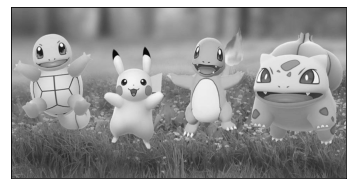

In [4]:
class Images():
    def __init__(self, image, title):
        self.image = image
        self.title = title

def plotImages(images,dim, size=(20, 15)):                                               
  fig, ax = plt.subplots(dim[0],dim[1],figsize=size)
  ax = ax.ravel()
  for i,image in enumerate(images):
    ax[i].imshow(image.image, cmap='gray',vmin = 0,vmax = 255)
    ax[i].set_title(image.title)
    ax[i].set_xlabel('Width [px]')
    ax[i].set_ylabel('Height [px]')
  plt.tight_layout()

  plt.show()

img = color.rgb2gray(io.imread('pokemon.jpg'))
img = img_as_ubyte(img)
print ('Image shape:{}, Image data type:{}'.format(img.shape,img.dtype))
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X & Y axis
plt.show()


# Part 1: Quantization
___

1. Insert your function quant_img(img, N) from the preliminary report.

In [5]:
# Insert your code:
def quant_img(img,N=256):
  f_max = img.max()
  f_min = img.min()
  dynamic = f_max - f_min
  q_img = np.floor((img/dynamic)*N)/N 
  return img_as_ubyte(q_img)

2. Load the image of your choise as gray scale image and perform uniform quantization on your image to **2, 4, 8, 16, 32 and 64** gray levels.   
    From which quantization factor do you observe the problem of **false contours**? Attach relevant examples from the quantized images to demonstrate your answer.

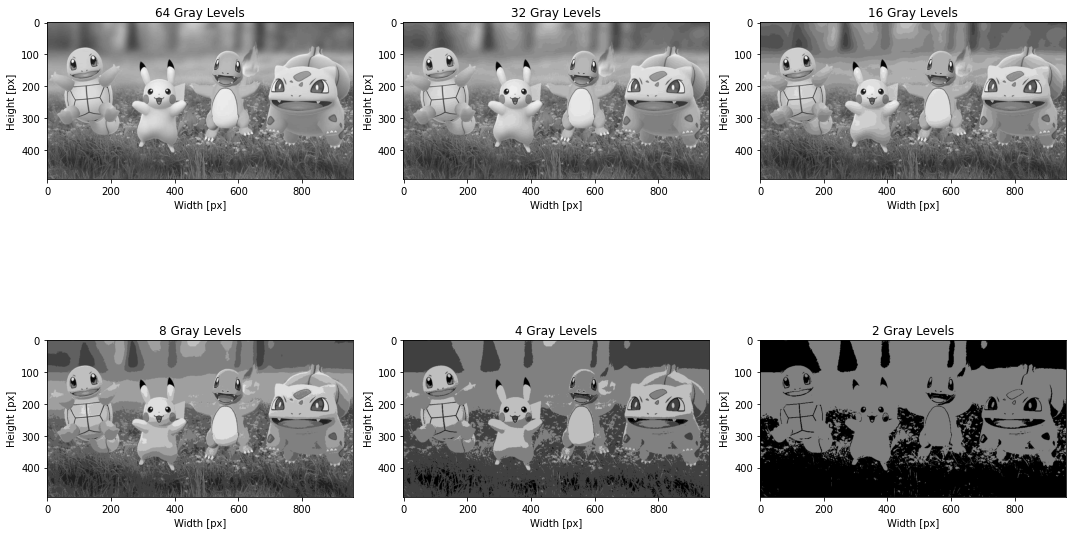

In [6]:
# Insert your code:
q_img = []
Q = [64,32,16,8,4,2]
for q in Q :
  q_img.append(Images(quant_img(img,q),str(q) + " Gray Levels" ))

plotImages(q_img, [2,3], (15, 10))


### Answer1
---
1. From quantization factor 8 we can see that some non-natural spots apears on the woman's forhead (for example), so-called gray levels contours.

2. We can see that while we represent the image with less than 16 grayscale levels, there are new false contours and edges that did not appear on the original image. It is possible to observe that by focusing on the background becomes with more sharp changes that make the new false edges. In addition, if we'd look at the Pokemons' bodies (i.e. Pikachu) the gray shades are not uniform in contrast to the original image. We can also say that the phenomena we described above become more significant as the number of grayscale levels is reduced.

---

3. Use the supplied function *imnoise()*, that adds Gaussian noise, on the image before quantization and test the effect on the false contours problem. Use zero mean noise with several values of variance.   
    You can use the quantization level that you chose in the previous section.
    
    What value of variance yields the optimal result? Attach examples of the quantized images with optimal and non-optimal variance values.

In [7]:
def imnoise(img, mean, std):
    noisy_img = img + np.random.normal(mean, std, img.shape)
    return np.clip(noisy_img, 0, 255)  # keep the bounds 

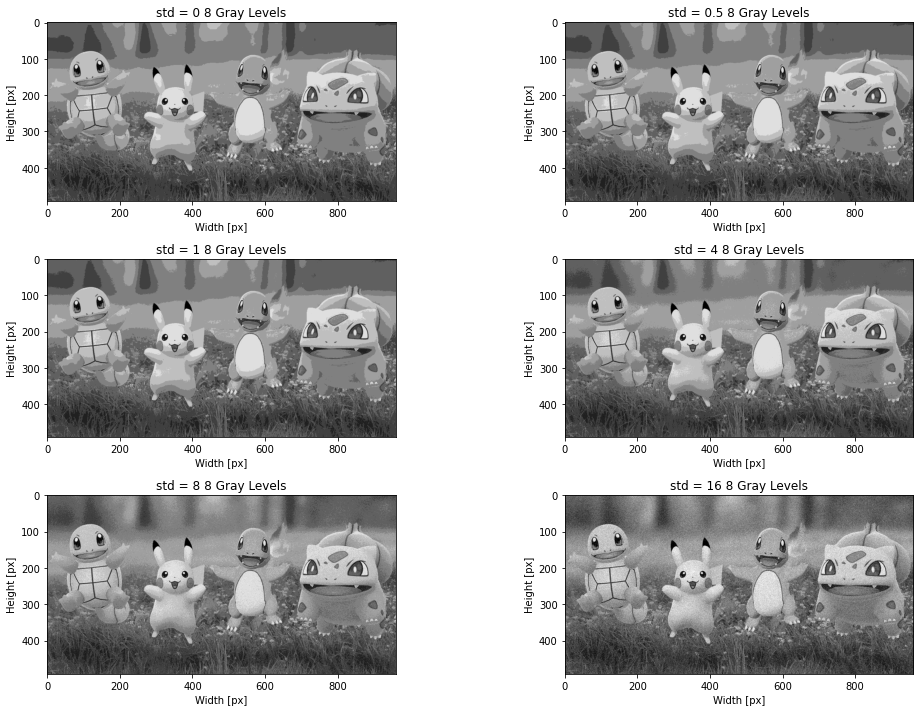

In [8]:
# Insert your code:
v_img = []
V = [0 ,0.5,1,4,8,16]
for v in V :
  v_img.append(Images(quant_img(imnoise(img, 0, v),8),"std = " + str(v) + " 8 Gray Levels" ))

plotImages(v_img,[3,2],(15, 10))

Write your answer here

### Answer 2
---
In the previous section, we saw that contours and false edges appeared when we reduced the quantization factor (number of grayscale levels).
In fact, we made a higher jump between neighboring pixels, which caused these phenomena to occur.
An optional solution is to add independent Gaussian noise to the image that will change the pixel values ​​according to the variance before the quantization procedure and we will get an image where the neighboring pixels no longer have similar grayscale intensity values. The greater the difference, the greater the probability of getting 2 neighboring pixels with a different value (in the real image this usually does not happen).
In the experiment result above we can see that the false contours were removed by noise with variance 8, having a noisy image. We can also say that if we increase the variance, the image of the false contour phenomena will be reduced but the image will be much noisier. So, in our case, we chose the optimal variance to be 8.

---

4. perform quantization on your image using K-means to **2, 4, 8, 16, 32 and 64** gray levels. You may use the provided function. Plot the resulting histograms of both methods. What is the main difference?
    Compare your results to the results from the previous section.

In [9]:
def kmeans_quant_img(img,N):
    m,n = img.shape
    np.random.seed(0)
    image_array = img.reshape(-1,1)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]
    kmeans = cluster.KMeans(n_clusters= N).fit(image_array_sample)   
    labels = kmeans.predict(image_array)
    q_img = np.zeros_like(img)
    label_idx = 0
    for i in range(m):
        for j in range(n):
            q_img[i][j] = kmeans.cluster_centers_[labels[label_idx]]
            label_idx += 1

    return q_img

In [10]:
# Insert your code:
k_img = []
K = [64,32,16,8,4,2]
for k in K :
  k_img.append(Images(kmeans_quant_img(img,k),"K = " + str(k)   ))

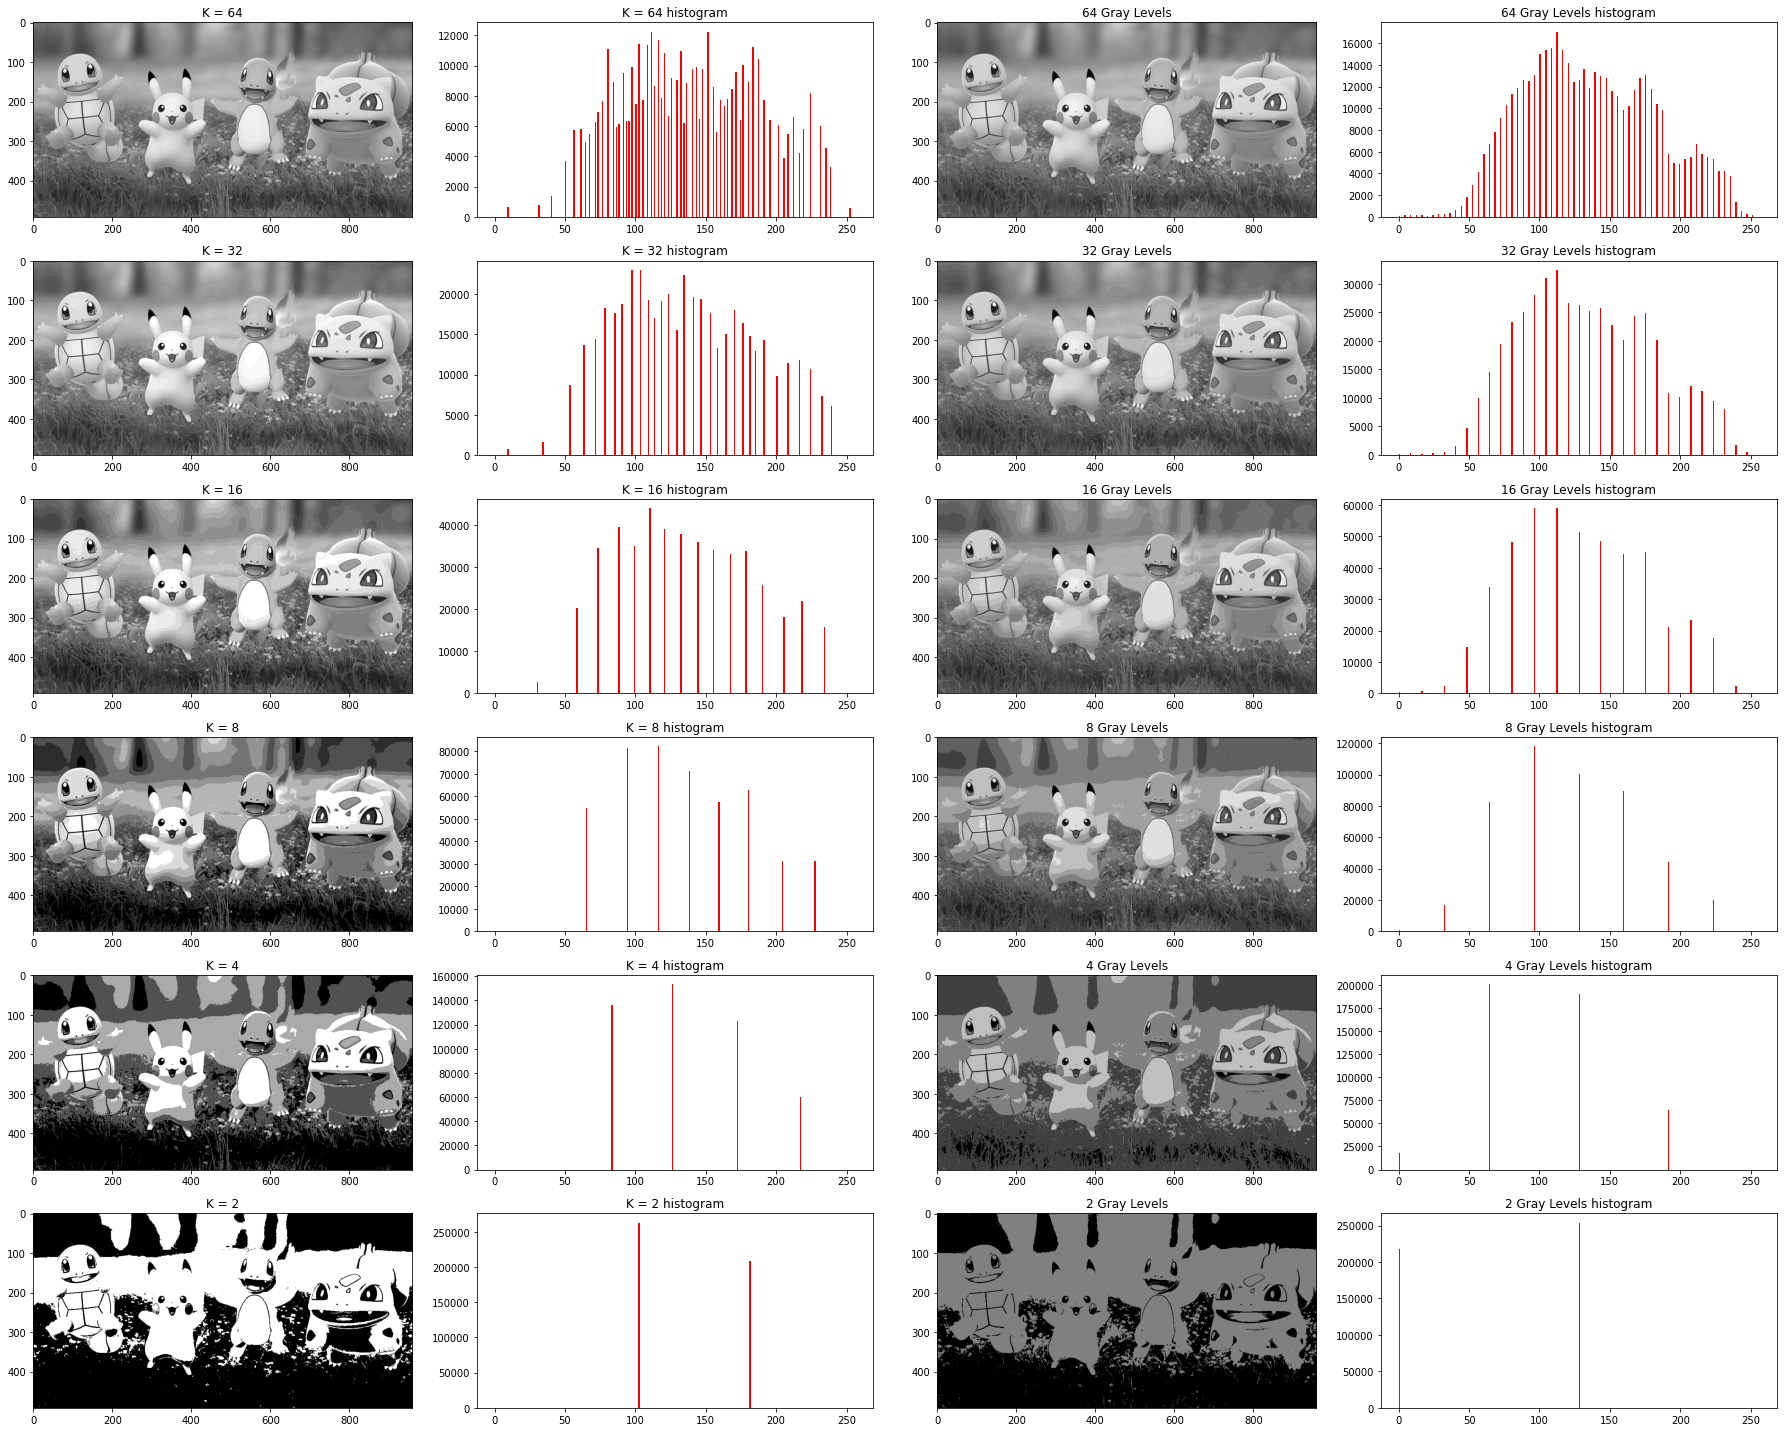

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(25, 20))

# K-means images
ax[0,0].imshow(k_img[0].image, cmap = 'gray'); ax[0,0].set_title(k_img[0].title)
ax[1,0].imshow(k_img[1].image, cmap = 'gray'); ax[1,0].set_title(k_img[1].title)
ax[2,0].imshow(k_img[2].image, cmap = 'gray'); ax[2,0].set_title(k_img[2].title)
ax[3,0].imshow(k_img[3].image, cmap = 'gray'); ax[3,0].set_title(k_img[3].title)
ax[4,0].imshow(k_img[4].image, cmap = 'gray'); ax[4,0].set_title(k_img[4].title)
ax[5,0].imshow(k_img[5].image, cmap = 'gray'); ax[5,0].set_title(k_img[5].title)
# K-means histograms
ax[0,1].hist(k_img[0].image.flatten(),256,[0,256], color = 'r'); ax[0,1].set_title(k_img[0].title + ' histogram')
ax[1,1].hist(k_img[1].image.flatten(),256,[0,256], color = 'r'); ax[1,1].set_title(k_img[1].title + ' histogram')
ax[2,1].hist(k_img[2].image.flatten(),256,[0,256], color = 'r'); ax[2,1].set_title(k_img[2].title + ' histogram')
ax[3,1].hist(k_img[3].image.flatten(),256,[0,256], color = 'r'); ax[3,1].set_title(k_img[3].title + ' histogram')
ax[4,1].hist(k_img[4].image.flatten(),256,[0,256], color = 'r'); ax[4,1].set_title(k_img[4].title + ' histogram')
ax[5,1].hist(k_img[5].image.flatten(),256,[0,256], color = 'r'); ax[5,1].set_title(k_img[5].title + ' histogram')
# Quantization images
ax[0,2].imshow(q_img[0].image, cmap = 'gray'); ax[0,2].set_title(q_img[0].title)
ax[1,2].imshow(q_img[1].image, cmap = 'gray'); ax[1,2].set_title(q_img[1].title)
ax[2,2].imshow(q_img[2].image, cmap = 'gray'); ax[2,2].set_title(q_img[2].title)
ax[3,2].imshow(q_img[3].image, cmap = 'gray'); ax[3,2].set_title(q_img[3].title)
ax[4,2].imshow(q_img[4].image, cmap = 'gray'); ax[4,2].set_title(q_img[4].title)
ax[5,2].imshow(q_img[5].image, cmap = 'gray'); ax[5,2].set_title(q_img[5].title)
# Quantization histograms
ax[0,3].hist(q_img[0].image.flatten(),256,[0,256], color = 'r'); ax[0,3].set_title(q_img[0].title + ' histogram')
ax[1,3].hist(q_img[1].image.flatten(),256,[0,256], color = 'r'); ax[1,3].set_title(q_img[1].title + ' histogram')
ax[2,3].hist(q_img[2].image.flatten(),256,[0,256], color = 'r'); ax[2,3].set_title(q_img[2].title + ' histogram')
ax[3,3].hist(q_img[3].image.flatten(),256,[0,256], color = 'r'); ax[3,3].set_title(q_img[3].title + ' histogram')
ax[4,3].hist(q_img[4].image.flatten(),256,[0,256], color = 'r'); ax[4,3].set_title(q_img[4].title + ' histogram')
ax[5,3].hist(q_img[5].image.flatten(),256,[0,256], color = 'r'); ax[5,3].set_title(q_img[5].title + ' histogram')

plt.tight_layout()
plt.show()

Write your answer here

### Answer 3
---
Firstly we will notice that we've got a difference between the gray scale levels that the algorithms used. Actually it is expected since the quantization devide the image range to be equal while the k-mean algorithm finds in our case 2 clusters according to the pixel's values. Therefore, in our quantization algorithm we got f=0 and f=128 while in their 2-means algorithm, the grayscale levels are 100 & 175 that resulting a sharper image. This difference affect the histogram such that, the k-means hustograms are more equalized.

We want to do additional small experiemnt below, and we will apply histogram equalization and then we will compare the result to the k-means algoritem.



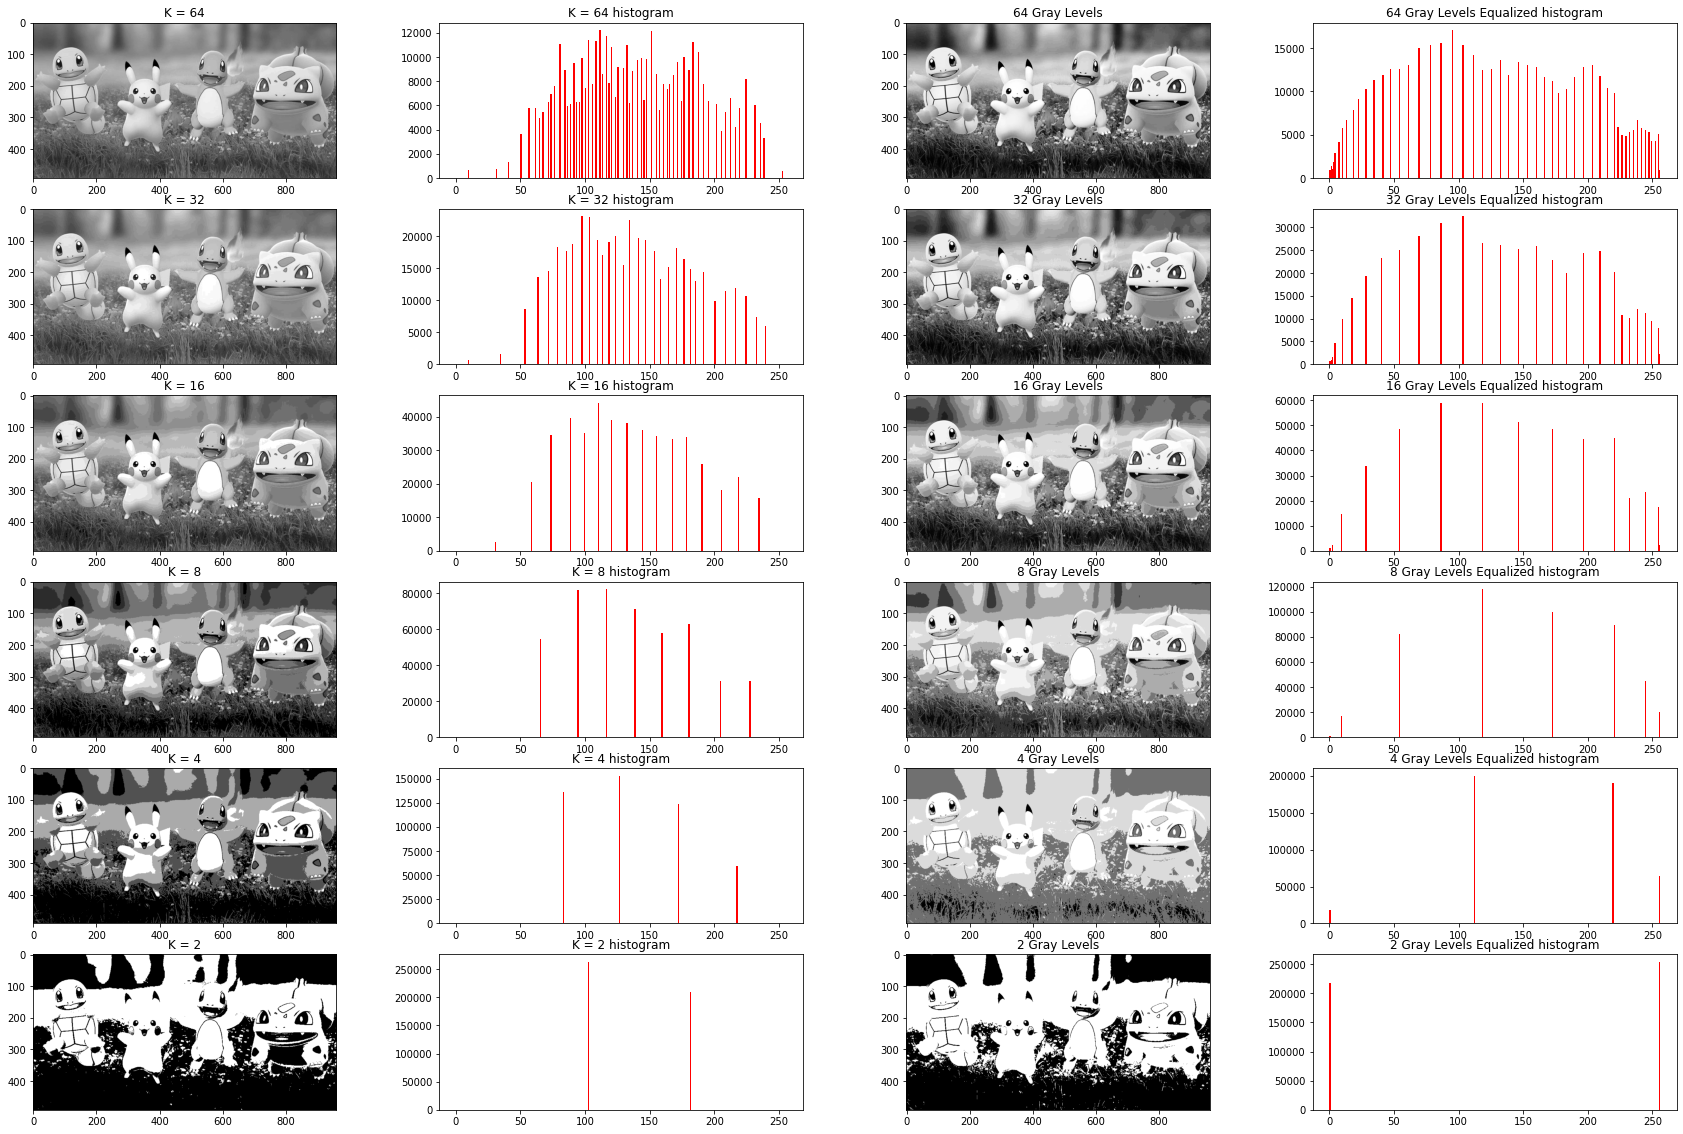

In [18]:
q_img_eq = []
for q in q_img:
  q_img_eq.append(Images(cv2.equalizeHist(q.image), q.title+ " equalized ") )

fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(30, 20))
ax[0,0].imshow(k_img[0].image, cmap = 'gray'); ax[0,0].set_title(k_img[0].title)
ax[1,0].imshow(k_img[1].image, cmap = 'gray'); ax[1,0].set_title(k_img[1].title)
ax[2,0].imshow(k_img[2].image, cmap = 'gray'); ax[2,0].set_title(k_img[2].title)
ax[3,0].imshow(k_img[3].image, cmap = 'gray'); ax[3,0].set_title(k_img[3].title)
ax[4,0].imshow(k_img[4].image, cmap = 'gray'); ax[4,0].set_title(k_img[4].title)
ax[5,0].imshow(k_img[5].image, cmap = 'gray'); ax[5,0].set_title(k_img[5].title)

ax[0,1].hist(k_img[0].image.flatten(),256,[0,256], color = 'r'); ax[0,1].set_title(k_img[0].title + ' histogram')
ax[1,1].hist(k_img[1].image.flatten(),256,[0,256], color = 'r'); ax[1,1].set_title(k_img[1].title + ' histogram')
ax[2,1].hist(k_img[2].image.flatten(),256,[0,256], color = 'r'); ax[2,1].set_title(k_img[2].title + ' histogram')
ax[3,1].hist(k_img[3].image.flatten(),256,[0,256], color = 'r'); ax[3,1].set_title(k_img[3].title + ' histogram')
ax[4,1].hist(k_img[4].image.flatten(),256,[0,256], color = 'r'); ax[4,1].set_title(k_img[4].title + ' histogram')
ax[5,1].hist(k_img[5].image.flatten(),256,[0,256], color = 'r'); ax[5,1].set_title(k_img[5].title + ' histogram')

ax[0,2].imshow(q_img_eq[0].image, cmap = 'gray'); ax[0,2].set_title(q_img[0].title)
ax[1,2].imshow(q_img_eq[1].image, cmap = 'gray'); ax[1,2].set_title(q_img[1].title)
ax[2,2].imshow(q_img_eq[2].image, cmap = 'gray'); ax[2,2].set_title(q_img[2].title)
ax[3,2].imshow(q_img_eq[3].image, cmap = 'gray'); ax[3,2].set_title(q_img[3].title)
ax[4,2].imshow(q_img_eq[4].image, cmap = 'gray'); ax[4,2].set_title(q_img[4].title)
ax[5,2].imshow(q_img_eq[5].image, cmap = 'gray'); ax[5,2].set_title(q_img[5].title)

ax[0,3].hist(q_img_eq[0].image.flatten(),256,[0,256], color = 'r'); ax[0,3].set_title(q_img[0].title + ' Equalized histogram')
ax[1,3].hist(q_img_eq[1].image.flatten(),256,[0,256], color = 'r'); ax[1,3].set_title(q_img[1].title + ' Equalized histogram')
ax[2,3].hist(q_img_eq[2].image.flatten(),256,[0,256], color = 'r'); ax[2,3].set_title(q_img[2].title + ' Equalized histogram')
ax[3,3].hist(q_img_eq[3].image.flatten(),256,[0,256], color = 'r'); ax[3,3].set_title(q_img[3].title + ' Equalized histogram')
ax[4,3].hist(q_img_eq[4].image.flatten(),256,[0,256], color = 'r'); ax[4,3].set_title(q_img[4].title + ' Equalized histogram')
ax[5,3].hist(q_img_eq[5].image.flatten(),256,[0,256], color = 'r'); ax[5,3].set_title(q_img[5].title + ' Equalized histogram')
plt.show()

We still did not get the same result as in the k-meas algorithm, but we can see that the results are much better. In our opinion, the k-means images seem better as the grayscale levels are smaller.

---

# Part 2: Histogram Manipulation
___

Use the supplied function hist_demo().  
* Observe the following demonstrations:
  * Contrast stretching.
  * Histogram equalization.

In [20]:
def my_hist(img):
  histogram = np.histogram(img, bins=list(range(0,257)))
  return histogram[0]
def my_hist_eq(img):
  cs = my_hist(img)
  for i in range(1,len(cs)):
   cs[i] += cs[i-1]

  nj = (cs - cs.min()) * 255
  N = cs.max() - cs.min()

  # re-normalize the cumsum
  cs = nj / N

  # cast it back to uint8 since we can't use floating point values in images
  cs = cs.astype('uint8')
  flat = img.flatten()
  img_q = cs[flat]

  # put array back into original shape since we flattened it
  img_q = np.reshape(img_q, img.shape)
  return img_q


In [21]:
def hist_demo(img):
    # Contrast stretching
    img_dbl = np.float64(img)
    min_im = np.min(np.min(img_dbl))
    max_im = np.max(np.max(img_dbl))
    img_stretched_contrast = np.uint8(255*(img_dbl-min_im)/(max_im-min_im))
    
    # Histogram equalization
    #Use your own hist_eq function
    img_hist_eq = my_hist_eq(img) 
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Original image")
    # Use your own hist function
    hist = my_hist(img)
    ax[1].plot(hist)
    ax[1].set_title("Original image histogram")  
    plt.tight_layout(); plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img_stretched_contrast, cmap='gray')
    ax[0].set_title("Contrast stretching image")
    # Use your own hist function
    hist = my_hist(img_stretched_contrast)
    ax[1].plot(hist)
    ax[1].set_title("Contrast stretching histogram")
    plt.tight_layout(); plt.show()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(img_hist_eq, cmap='gray')
    ax[0].set_title("Histogram equalization image")
    # Use your own hist function
    hist = my_hist(img_hist_eq)
    ax[1].plot(hist)
    ax[1].set_title("Histogram equalization histogram")
    plt.tight_layout(); plt.show()

Image shape:(533, 800), Image data type:uint8


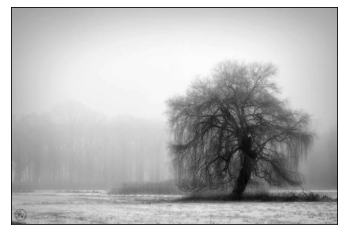

In [22]:
# Insert your code:
img = color.rgb2gray(io.imread('LowContrast.jpeg'))
img = img_as_ubyte(img)
print ('Image shape:{}, Image data type:{}'.format(img.shape,img.dtype))
plt.imshow(img, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X & Y axis
plt.show()

1. Load a **gray image** of your choise ans test these demonstrations. Make sure that the image you choose is indeed affected by both operations.   
    On which images contrast stretching won’t affect?  On which images histogram equalization won’t affect?\
    Use your own **hist** and **hist_eq** functions to complete the demo.\
    If your functions don't work properly use ***opencv*** to calculate the histogram and the histogram equalization.
    
    Note: 
    If you are experiencing any errors, try to convert the image to uint8 with image_as_ubyte (as we did in the first lab) before using the suplied function.

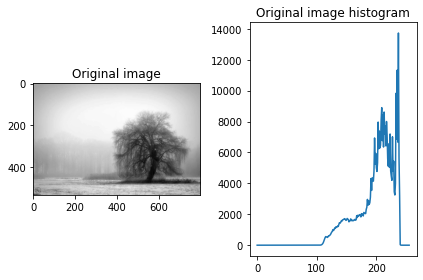

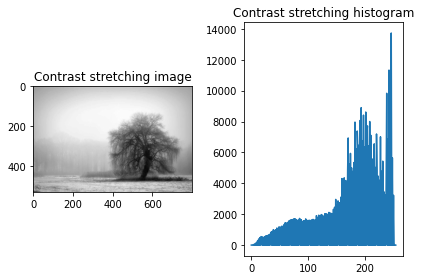

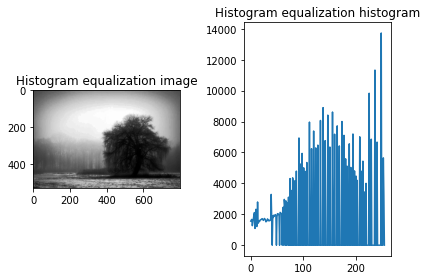

In [23]:
hist_demo(img)

Write your answer here
### Answer 4
---
When we stretch the contrast we actually increase the image's dynamic range to the full dynamic range (0-255). We'd like to note that in case the dynamic range is already covered (even if with low numbers of pixels - ie 1 pixel at 0 and 1 pixel at 255 and all other pixels in between), nothing will happen.

And we can see that by the following formula:

img_stretched_contrast = np.uint8(255*(img_dbl-min_im)/(max_im-min_im))

If the minimum is 0 and the maximum is 255, we will get

img_stretched_contrast = np.uint8(255*(img_dbl-0)/(255)) =  np.uint8((img_dbl)

We will not get any impact of the histogram equalization on the original image. This property is actually good for us because we would not want to distroy uniformal distributed image. As a result the distribution function will be stairs function, and then, every pixel in the dst image will be equal to the src image.

---

### Answers 4.1 & 4.2
---
Additional Answers for the Lab Giuidlines Document:

1. If we want to turn an image into a binary image (2 grayscale levels) then with a given histogram that includes exactly 2 grayscale levels we can do the histogram classification as we do in the next section below. When we take an image and adjust its histogram to another binary histogram (N=2) we will theoretically get a binary image. But in practice, something wrong can happen because the image is a discrete and non-continuous signal. Alternatively, we can use the 2 levels from the histogram as threshold values and thus convert an image to binary.

2. Contrast stretching is increasing the difference between the maximum and minimum grayscale level values in an image, and the other pixels' intensities values are spread out between this range. Histogram equalization is modifying the pixels' grayscale values in order to flat the histogram to reach out a uniform distribution, with the problem that we mentioned previously in this report. Since in contrast stretching there exists a linear relationship between the images before and after the transformation, the original image can be restored from the contrast-stretched image. Wile we can't reproduce an image after histogram equalization process. 

---


## Part 3: Histogram Specification

1. Complete the following code to create your own histogram specification function. Use only *numpy* functions, you may use *opencv* for histogram and histogram equalization calculations.\
The function will take two images: *src*, *ref*. *src* is the source image that undergoes the histogram specification. *ref* is the reference image with the taget histogram.
The algorithm should do the following:
*	Calculate the CDFs of both images: CDF_src, CDF_ref
*	Find for every CDF_src value the corresponding CDF_ref value
*	Apply the inverse of CDF_ref on the corresponding CDF_ref values

\
Helpful numpy functions: *np.unique*, *np.argmin*, *np.where*


Image shape:(492, 960), Image data type:uint8


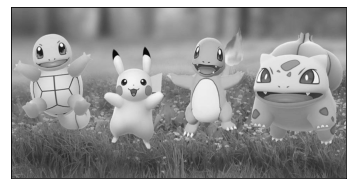

In [24]:
# Insert your code:

src = color.rgb2gray(io.imread('pokemon.jpg'))
src = img_as_ubyte(src)
print ('Image shape:{}, Image data type:{}'.format(src.shape,src.dtype))
plt.imshow(src, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X & Y axis
plt.show()

Image shape:(492, 960), Image data type:uint8


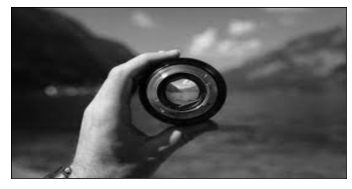

In [31]:
ref = color.rgb2gray(io.imread('circle.jpg'))
ref = resize(ref, src.shape,
                       anti_aliasing=True)
ref = img_as_ubyte(ref)
print ('Image shape:{}, Image data type:{}'.format(ref.shape,ref.dtype))
plt.imshow(ref, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X & Y axis
plt.show()

In [32]:
# Complete the following code skeleton:
def hist_spec(src, ref):
  """
  This is the skeleton for your image specification function.
  INPUT: src - an [H1 X W1] numpy array as float32 (a grayscale image with values between 0 to 1)
         ref - an [H2 X W2] numpy array as float32 (a grayscale image with values between 0 to 1)

  OUTPUT: im_out - an [H1 X W1] image as float32 (a grayscale image with values between 0 to 1)
  """
  
  oldshape = src.shape
  src = src.ravel()
  ref = ref.ravel()

  # get the set of unique pixel values and their corresponding indices and
  # counts
  s_values, bin_idx, s_counts = np.unique(src, return_inverse=True,
                                          return_counts=True)
  t_values, t_counts = np.unique(ref, return_counts=True)

  # take the cumsum of the counts and normalize by the number of pixels to
  # get the empirical cumulative distribution functions for the source and
  # template images (maps pixel value --> quantile)
  cdf_s = np.cumsum(s_counts).astype(np.float64)
  cdf_s /= cdf_s[-1]
  cdf_r = np.cumsum(t_counts).astype(np.float64)
  cdf_r /= cdf_r[-1]

  # interpolate linearly to find the pixel values in the template image
  # that correspond most closely to the quantiles in the source image
  im_out = np.interp(cdf_s,cdf_r, t_values)

  return im_out[bin_idx].reshape(oldshape)


  # ----------------------------------------------------
 


2. Test your function with two different images, show the source image and its histogram before and after transformation.

In [33]:
def plot_RGB(src,ref,matched1,matched2):

    plt.figure(figsize=(15,10))
    plt.subplot(422)
    plt.imshow(src,cmap='gray')
    plt.title("Source")
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(424)
    plt.imshow(ref,cmap='gray')
    plt.title("REF")
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(426)
    plt.imshow(matched1,cmap='gray')
    plt.title("Matched Image Our Algorithm")
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(428)
    plt.imshow(matched2,cmap='gray')
    plt.title("Matched Image skimage Algorithm")
    plt.subplots_adjust(hspace=0.5)
    images = [src,ref,matched1,matched2]
    color = ('r','g','b','b')
    titles = ("src","ref" ,"match" , "skimage match")
    for i,col in enumerate(color):
        histr = cv2.calcHist([images[i]],[0],None,[256],[0,256])
        plt.subplot(i*2+421)                             # 311 -> plot in the first cell
        plt.plot(histr,color = col)
        plt.xlim([0,256])
        plt.subplots_adjust(hspace=.5)
        plt.title(str(titles[i]))

    plt.show()

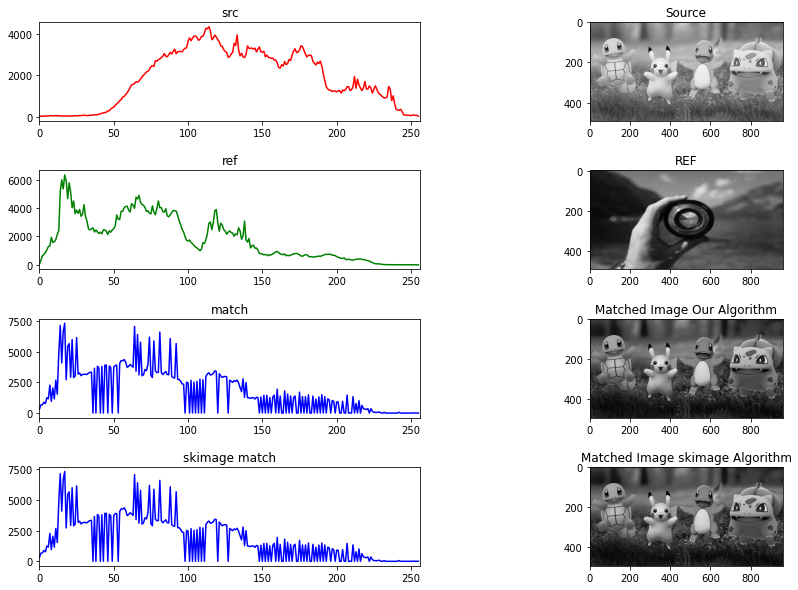

In [34]:
# Insert your code:
from skimage.exposure import match_histograms
matched1 = hist_spec(src,ref).astype('uint8')

matched2 = match_histograms(src, ref).astype('uint8')

plot_RGB(src,ref,matched1,matched2)

3. Read about the **match_histograms** function from *skimage*.\
What does the function do? Take 2 different grayscale images and apply on them the **match_histograms** function. Show the output image and compare its histogram to the reference image's histogram. Is the result different from your implementation? Why?

Write your answer here
### Answer 5
---
We can see that the results of our implimentation are the same as the reults of the built-in function.
The function matches the hitogram of a given image to another histogram of another image. Since in the real world we are dealing with disctric images with values between 0-255, we got a noisy image (many jumps in the grayscale levels).

We note that the histogram we've got is similar to the histogram of the reference image. It is very clearly where the histograms have peaks - they are similar to the ref image and also their location on the range is similar.

---


4. Calculate the distance between the refernce histogram and the source histogram, and the distance between the refernce histogram and the output histogram. How is the distance affected by histogram specification?
Do this comparison for **your function** and for skimage **match_histograms** as well.

Use ***scipy.stats.wasserstein_distance*** to calculate the distances between histograms.

In [35]:
# Insert your code:
from scipy.stats import wasserstein_distance
src_hist = my_hist(src)
ref_hist = my_hist(ref)
matched1_hist = my_hist(matched1)
matched2_hist = my_hist(matched2)
print("the distance between the src image to the ref image :" + str(wasserstein_distance(src_hist.flatten(),ref_hist.flatten())))
print("the distance between the our matched image to the ref image :" + str(wasserstein_distance(matched1_hist.flatten(),ref_hist.flatten())))
print("the distance between the skiimage matche image to the ref image :" + str(wasserstein_distance(matched2_hist.flatten(),ref_hist.flatten())))

the distance between the src image to the ref image :369.734375
the distance between the our matched image to the ref image :310.7109375
the distance between the skiimage matche image to the ref image :310.7109375


Write your answer here

### Answer 6
---
1. As we expected, the distance between src image and the ref image was decreased. 

2. In addition, we will notice that we've got the same distance as in the built-in skimage function.

---


# Part 3: Camshift Algorithm


1. We now test the Camshift algorithm for video tracking, as explained in the Lab Manual. Given is a demo script, which loads a short video file 'MOT16-04-trimmed.mp4' from the MOT16 dataset and writes a new video file 'output.mp4' displaying the tracked object. Modify the initial ROI coordinates so that the algorithm tracks an object to your liking and observe the results.

2. Attach several captured frames of the tracked object to your report and answer the following: 
* What color space is used here for tracking and why? 
* What is the main disadvantage of the given algorithm?

Write your answer here
### Answer 7
---

In the preliminary report we saw that the algorithm takes the first frame in the video with our chosen ROI and perform histogram according to its color's channel on the same range. after that it is going over a window with the shape that we defined and calculates pixel-wise what is the probability that a given pixel belong to our object. according to the histogram we performed at the begginging on the color's chanel, we expect that the color space will be HSV.

The obvious disadvantage of the algorithm is that it will not be able to identify the object if the background has the same color as its own, or alternatively if between frame and frame there is another object with the same color as its own. In addition, as mentioned, this algorithm is based on the color channel and sometimes the color is meaningless. For example, if we want to identify cars like as autonomous car works, we want to recognize cars in the image regardless of their color. Also, if there is another object with the same color an error will be generated!

---


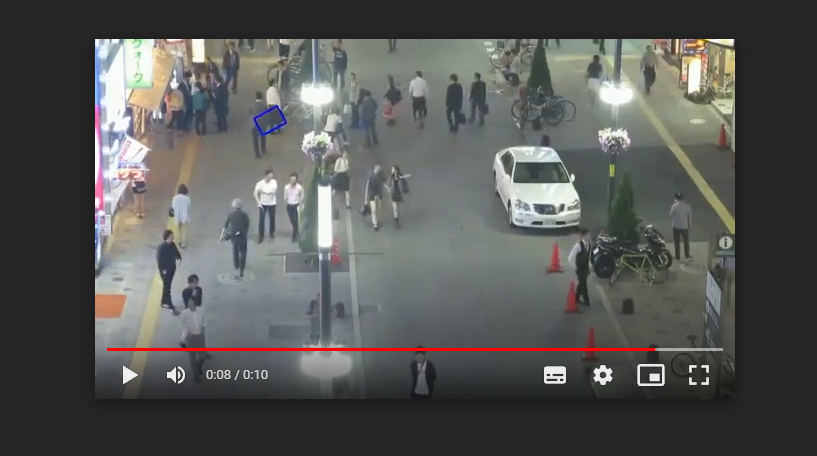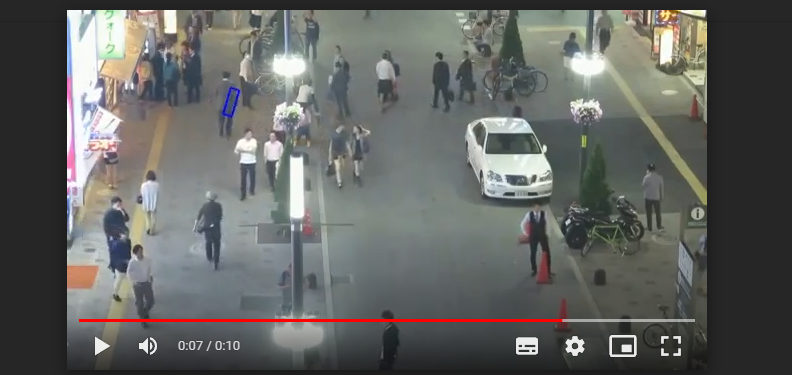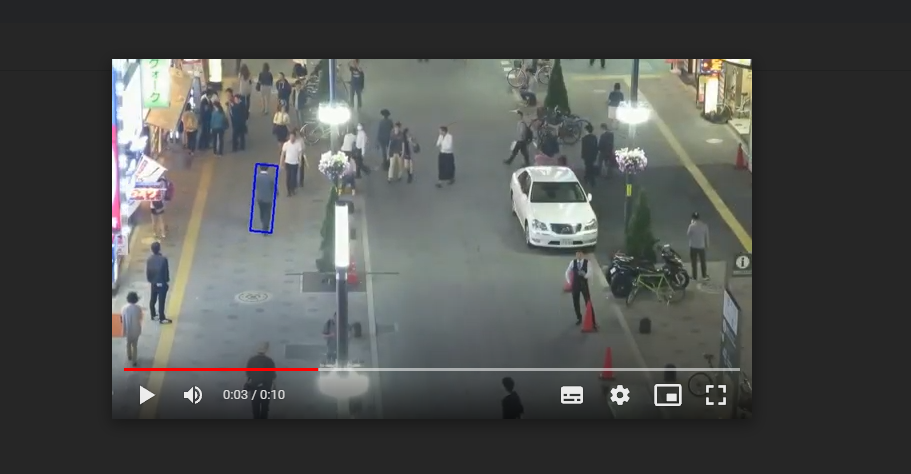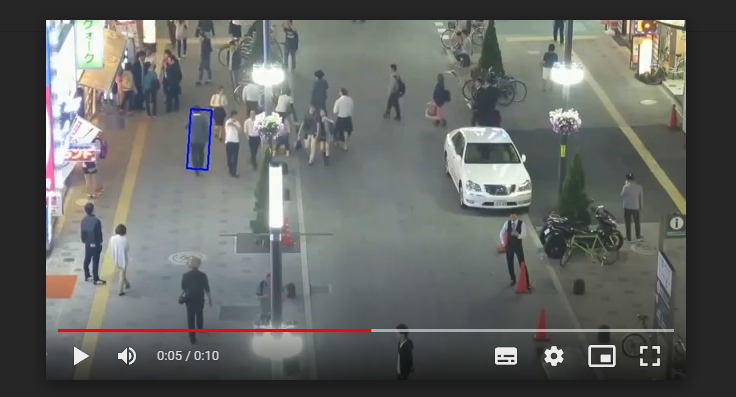

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

cap = cv2.VideoCapture('MOT16-04-trimmed.mp4')

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width,frame_height))

# take first frame of the video
ret,frame = cap.read()

# setup initial location of window
#### INSERT THE ROI VALUES HERE ###
x,h,y,w = 190, 110, 210, 30
track_window = (x,y,w,h)

# set up the ROI for tracking
roi = frame[y:y+h, x:x+w]

# convert ROI to HSV
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# create ROI normalized histogram
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while(1):
    ret ,frame = cap.read()

    if ret == True:
        # convert frame to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        # get probabilty map
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)

        # apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        
        # draw window on frame
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        k = cv2.waitKey(60) & 0xff
        
        if k == 27:
            break
        else:
            # Write the frame into the file 'output.avi'
            out.write(img2)

    else:
        break

cv2.destroyAllWindows()
cap.release()
out.release()